# 0. Import Libaries + Data

In [1]:
!pip install changepoynt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
import matplotlib.dates as mdates

from datetime import datetime
import dateutil.parser
import copy

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from model import *
from preprocess import *
from crawling import *

In [15]:
start_time = '2017-12-31'
# start_time = '2023-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

daily_full = VN_Stock_fully_data(start_time, end_time)

# 1. Analysis

In [53]:
def describe_data_list(data):
  ''' Hàm mô tả dữ liệu
      INPUT: data_list(list): Một list bao gồm các dataframe
        * Lưu ý: Nếu chỉ sử dụng 1 công ty, chỉ cần truyền vào 1 dataframe dưới dạng list: (VD: [df])
      OUTPUT: các thông tin chung và mô tả các biến số của tất cả dataframe có trong list
  '''
  print(data.name)
  print(data.info())
  print(data.describe())
  print("=========================================")

  return

# 2. Cleaning Data

# 3. Feature Engineering

In [17]:
num_feature = feature_engineering(daily_full[:1000]).shape[1] - 2
train_feature = pd.DataFrame(np.empty((0, num_feature + 2)))
val_feature = pd.DataFrame(np.empty((0, num_feature + 2)))
test_feature = pd.DataFrame(np.empty((0, num_feature + 2)))

train, val, test = split_train_test(daily_full)
for symbol in daily_full['Symbol'].unique():
        
    train_temp = feature_engineering(train[train["Symbol"] == symbol])
    train_feature.columns = train_temp.columns
    train_feature = pd.concat([train_feature,train_temp], axis = 0)

    val_temp = feature_engineering(val[val["Symbol"] == symbol])
    val_feature.columns = val_temp.columns
    val_feature = pd.concat([val_feature,val_temp], axis = 0)

    test_temp = feature_engineering(test[test["Symbol"] == symbol])
    test_feature.columns = test_temp.columns
    test_feature = pd.concat([test_feature,test_temp], axis = 0)



0.09762622222222224 7.127666666666667 10.918534177993486
0.11662988888888894 8.189 13.622788644672207
0.06655566666666657 14.961833333333335 0.3226979698765656
0.13831916666666672 20.12233333333333 3.097161528636064
2.651233611111112 30.18716666666667 449.870557756083
1.8489893888888878 77.18166666666666 13.89504170915952
3.338321611111112 64.32483333333333 17.942742544166673
0.9860180555555558 23.2495 16.76991069243107
0.44816222222222196 33.29083333333334 0.5326669727903934
1.093528555555555 39.361 8.987633881031904
4.535834777777779 53.23533333333333 178.00236485390764
0.7523113888888892 44.1375 2.5395416173192853
1.1030415555555566 42.492333333333335 14.469968379791675
0.890560888888889 18.998000000000005 37.582059904263716
0.2855629444444444 25.979833333333332 1.1618074567878056
0.7614513888888894 33.52916666666667 11.107563808505862
0.6790016111111108 24.081500000000002 295.8708313951657
1.475404888888889 60.31933333333333 49.52715867613791
9.97799472222222 125.81766666666665 571

In [23]:
trainX, trainY, info_train = prepare_X_y(train_feature.sort_index())
valX, valY, info_val = prepare_X_y(val_feature.sort_index())
testX, testY, info_test = prepare_X_y(test_feature.sort_index())

# 4. Model

## Random forest

In [ ]:
rf_model, rf_study = train_rf_optuna(trainX,trainY,valX, valY, n_trials = 100)

In [11]:
prediction = rf_model.predict(trainX)
print(classification_report(trainY, prediction))
    
values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     22858
         1.0       0.88      0.96      0.92     12619

    accuracy                           0.94     35477
   macro avg       0.93      0.94      0.94     35477
weighted avg       0.94      0.94      0.94     35477

{0.0: 21831, 1.0: 13646}


In [12]:
prediction = rf_model.predict(testX)
print(classification_report(testY, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      5851
         1.0       0.85      0.97      0.91      3415

    accuracy                           0.92      9266
   macro avg       0.91      0.93      0.92      9266
weighted avg       0.93      0.92      0.93      9266

{0.0: 5346, 1.0: 3920}


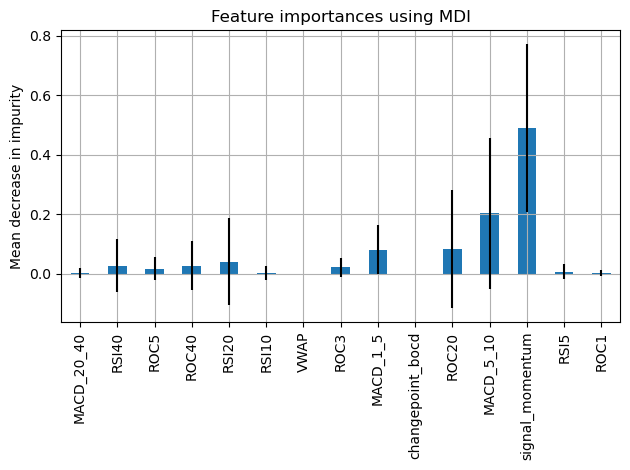

In [13]:
importances = rf_model.feature_importances_

# feature_names = trainX.drop(columns = ['Symbol']).columns

feature_names = trainX.columns


forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.grid()
fig.tight_layout()
plt.show()

## Lasso

In [ ]:
lasso_model, lasso_study = train_lasso_optuna(trainX,trainY,valX, valY, num_feature= num_feature- 2 ,n_trials = 100)

In [16]:
prediction = (lasso_model.predict(trainX) > 0.5).astype(int)
print(classification_report( trainY, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91     22858
         1.0       0.84      0.85      0.84     12619

    accuracy                           0.89     35477
   macro avg       0.88      0.88      0.88     35477
weighted avg       0.89      0.89      0.89     35477

{0: 22712, 1: 12765}


In [17]:
prediction = (lasso_model.predict(testX) > 0.5).astype(int)
print(classification_report( testY, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      5851
         1.0       0.85      0.86      0.86      3415

    accuracy                           0.89      9266
   macro avg       0.89      0.89      0.89      9266
weighted avg       0.89      0.89      0.89      9266

{0: 5830, 1: 3436}


## MLP

In [ ]:
mlp_model, mlp_study = train_mlp_optuna(trainX,trainY,valX, valY, num_feature= num_feature- 2, n_trials = 100)

In [19]:
prediction = (mlp_model.predict(trainX) > 0.5).astype(int)
print(classification_report( trainY, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     22858
         1.0       0.95      0.92      0.93     12619

    accuracy                           0.95     35477
   macro avg       0.95      0.94      0.95     35477
weighted avg       0.95      0.95      0.95     35477

{0: 23273, 1: 12204}


In [20]:
prediction = (mlp_model.predict(testX) > 0.5).astype(int)
print(classification_report(testY, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95      5851
         1.0       0.90      0.92      0.91      3415

    accuracy                           0.94      9266
   macro avg       0.93      0.93      0.93      9266
weighted avg       0.94      0.94      0.94      9266

{0: 5774, 1: 3492}


## LSTM

In [16]:
sequence_length = 5

train_lstm, val_lstm, test_lstm = split_train_test(daily_full, lstm = True, sequence_length= sequence_length)


train_feature_lstm = pd.DataFrame(np.empty((0, num_feature + 2)))
val_feature_lstm = pd.DataFrame(np.empty((0, num_feature + 2)))
test_feature_lstm = pd.DataFrame(np.empty((0, num_feature + 2)))

for symbol in daily_full['Symbol'].unique():
        
    train_temp = feature_engineering(train_lstm[train_lstm["Symbol"] == symbol])
    train_feature_lstm.columns = train_temp.columns
    train_feature_lstm = pd.concat([train_feature_lstm,train_temp], axis = 0)

    val_temp = feature_engineering(val_lstm[val_lstm["Symbol"] == symbol])
    val_feature_lstm.columns = val_temp.columns
    val_feature_lstm = pd.concat([val_feature_lstm,val_temp], axis = 0)

    test_temp = feature_engineering(test_lstm[test_lstm["Symbol"] == symbol])
    test_feature_lstm.columns = test_temp.columns
    test_feature_lstm = pd.concat([test_feature_lstm,test_temp], axis = 0)

0.11662988888888894 8.189 13.622788644672207
0.06720055555555556 14.911333333333337 0.32158199806627136
0.13777655555555565 20.106666666666662 3.293111610830765
2.651233611111112 30.18716666666667 449.870557756083
1.793595666666667 77.29266666666668 11.409679272113507
3.354795666666665 64.29366666666667 17.7715965897699
0.9860180555555558 23.2495 16.76991069243107
0.4349512222222217 33.24966666666667 0.548168861101332
1.0172382222222223 39.30333333333332 9.91274631958554
4.535834777777779 53.23533333333333 178.00236485390764
0.7352765555555558 44.211666666666666 2.49403192794908
1.1070048888888904 42.45433333333333 14.485297396906255
0.890560888888889 18.998000000000005 37.582059904263716
0.2776648888888891 25.958999999999996 1.0681454473226804
0.7471916666666669 33.451666666666675 11.746300998368447
0.6790016111111108 24.081500000000002 295.8708313951657
1.252476000000001 59.91966666666666 40.75805184980636
9.651704555555552 124.93466666666667 582.6748239191942
6.968738277777778 65.09

In [8]:
feature_cols = train_feature_lstm.drop(columns=["Symbol","good_signal","Close","vol"]).columns


trainX_lstm, trainY_lstm = [], []
for company_id, group in train_feature_lstm.groupby("Symbol"):
    group = group.sort_index()
    features = group[feature_cols].values
    labels = group["good_signal"].values

    for i in range(len(group) - sequence_length):
        trainX_lstm.append(features[i:i+sequence_length])
        trainY_lstm.append(labels[i+sequence_length]) 


valX_lstm, valY_lstm = [], []
for company_id, group in val_feature_lstm.groupby("Symbol"):
    group = group.sort_index()
    features = group[feature_cols].values
    labels = group["good_signal"].values

    for i in range(len(group) - sequence_length):
        valX_lstm.append(features[i:i+sequence_length])
        valY_lstm.append(labels[i+sequence_length]) 


testX_lstm, testY_lstm = [], []
for company_id, group in test_feature_lstm.groupby("Symbol"):
    group = group.sort_index()
    features = group[feature_cols].values
    labels = group["good_signal"].values

    for i in range(len(group) - sequence_length):
        testX_lstm.append(features[i:i+sequence_length])
        testY_lstm.append(labels[i+sequence_length]) 


trainX_lstm = np.array(trainX_lstm).astype(np.float64)
trainY_lstm = np.array(trainY_lstm)  

valX_lstm = np.array(valX_lstm).astype(np.float64)
valY_lstm = np.array(valY_lstm)

testX_lstm = np.array(testX_lstm).astype(np.float64)
testY_lstm = np.array(testY_lstm)

print(trainX_lstm.shape)
print(trainY_lstm.shape)

print(valX_lstm.shape)
print(valY_lstm.shape)

print(testX_lstm.shape)
print(testY_lstm.shape)


(35357, 5, 10)
(35357,)
(3779, 5, 10)
(3779,)
(9296, 5, 10)
(9296,)


In [ ]:
lstm_model, lstm_study = train_lstm_optuna(trainX_lstm,trainY_lstm,valX_lstm, valY_lstm,n_trials = 100)

In [12]:
prediction = (lstm_model.predict(trainX_lstm) > 0.5).astype(int)
print(classification_report(trainY_lstm, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     21488
         1.0       0.80      0.84      0.82     11589

    accuracy                           0.87     33077
   macro avg       0.86      0.87      0.86     33077
weighted avg       0.87      0.87      0.87     33077

{0: 20937, 1: 12140}


In [13]:
prediction = (lstm_model.predict(testX_lstm) > 0.5).astype(int)
print(classification_report(testY_lstm, prediction))

values, counts = np.unique(prediction, return_counts=True)
print(dict(zip(values, counts)))

290/290 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      5851
         1.0       0.80      0.84      0.82      3415

    accuracy                           0.86      9266
   macro avg       0.85      0.86      0.85      9266
weighted avg       0.86      0.86      0.86      9266

{0: 5710, 1: 3556}


# 5. Evaluation

In [ ]:
# bestX, bestY, _ = prepare_X_y(train_feature[train_feature['signal_momentum'] > 0].sort_index())
# bestX

# desired_order = [
#     'MACD_20_40', 'RSI40', 'ROC5', 'ROC40', 'RSI20', 'RSI10',
#     'VWAP', 'ROC3', 'MACD_1_5', 'changepoint_bocd', 'ROC20',
#     'MACD_5_10', 'signal_momentum', 'RSI5', 'ROC1'
# ]

# bestX = bestX[desired_order]

# feature_cols = train_feature_lstm.drop(columns=["Symbol","good_signal","Close","vol"]).columns


# bestX_lstm, bestY_lstm = [], []

# for company_id, group in train_feature_lstm.groupby("Symbol"):
#     features = group[feature_cols].values
#     labels = group["good_signal"].values

#     for i in range(len(group) - sequence_length):
#         if features[i:i+sequence_length][-1,-1] > 0:
#             bestX_lstm.append(features[i:i+sequence_length])
#             bestY_lstm.append(labels[i+sequence_length]) 


# bestX_lstm = np.array(bestX_lstm).astype(np.float64)
# bestY_lstm = np.array(bestY_lstm)  

# print(bestX_lstm.shape)
# print(bestY_lstm.shape)


In [ ]:
# desired_order = [
#     'MACD_20_40', 'RSI40', 'ROC5', 'ROC40', 'RSI20', 'RSI10',
#     'VWAP', 'ROC3', 'MACD_1_5', 'changepoint_bocd', 'ROC20',
#     'MACD_5_10', 'signal_momentum', 'RSI5', 'ROC1'
# ]

# testX = testX[desired_order]
# trainX = trainX[desired_order]

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step


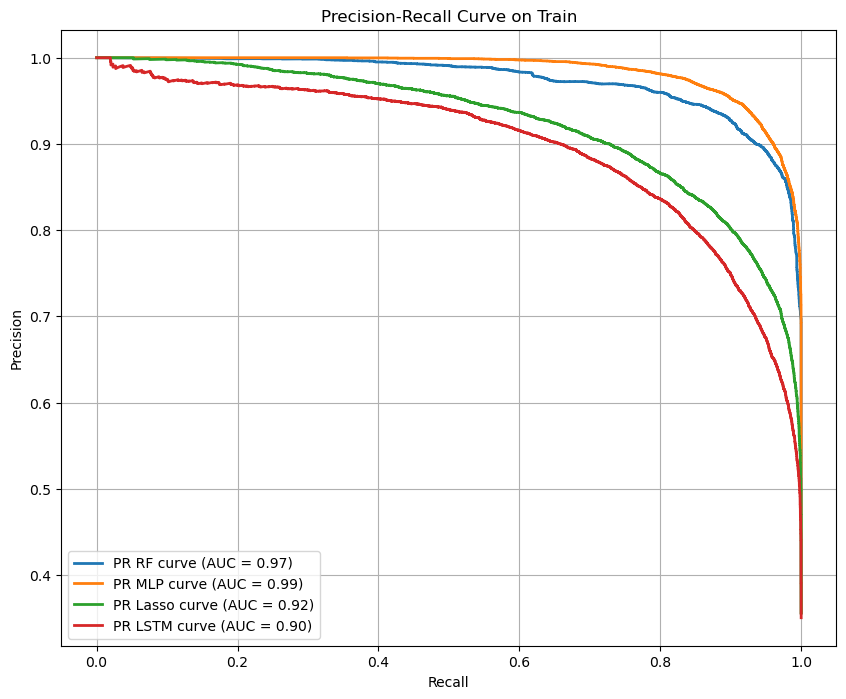

In [62]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

prediction_rf = rf_model.predict_proba(trainX)[:, 1]


precision, recall, _ = precision_recall_curve(trainY, prediction_rf)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR RF curve (AUC = {pr_auc:.2f})')

prediction_mlp = mlp_model.predict(trainX)


precision, recall, _ = precision_recall_curve(trainY, prediction_mlp)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR MLP curve (AUC = {pr_auc:.2f})')

prediction_lasso = lasso_model.predict(trainX)

precision, recall, _ = precision_recall_curve(trainY, prediction_lasso)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR Lasso curve (AUC = {pr_auc:.2f})')

prediction_lstm = lstm_model.predict(trainX_lstm)


precision, recall, _ = precision_recall_curve(trainY_lstm, prediction_lstm)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR LSTM curve (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Train')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()



290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
290/290 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


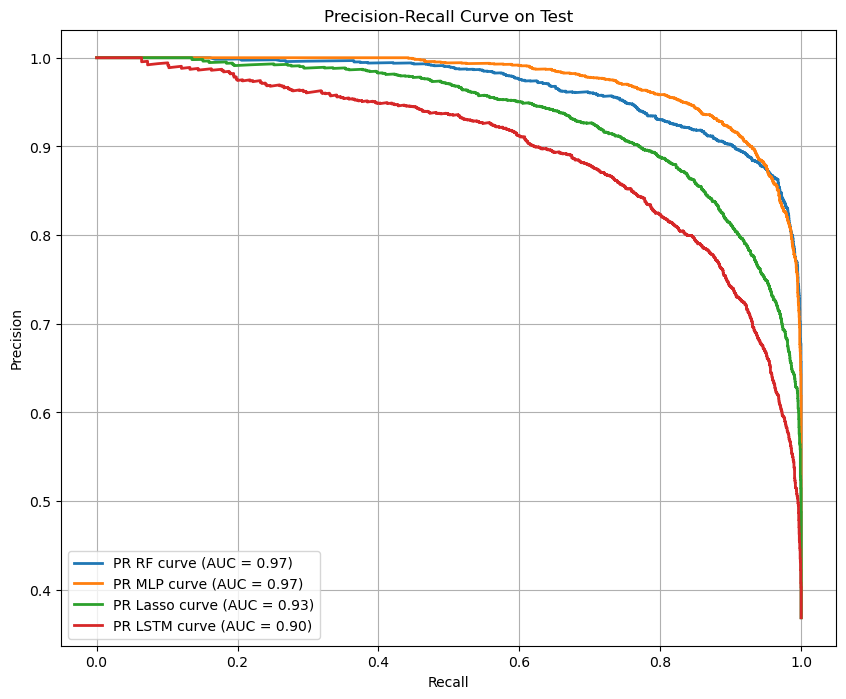

In [63]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

prediction_rf = rf_model.predict_proba(testX)[:, 1]

precision, recall, _ = precision_recall_curve(testY, prediction_rf)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR RF curve (AUC = {pr_auc:.2f})')

prediction_mlp = mlp_model.predict(testX)

precision, recall, _ = precision_recall_curve(testY, prediction_mlp)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR MLP curve (AUC = {pr_auc:.2f})')

prediction_lasso = lasso_model.predict(testX)

precision, recall, _ = precision_recall_curve(testY, prediction_lasso)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR Lasso curve (AUC = {pr_auc:.2f})')

prediction_lstm = lstm_model.predict(testX_lstm)
precision, recall, _ = precision_recall_curve(testY_lstm, prediction_lstm)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR LSTM curve (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()



572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step


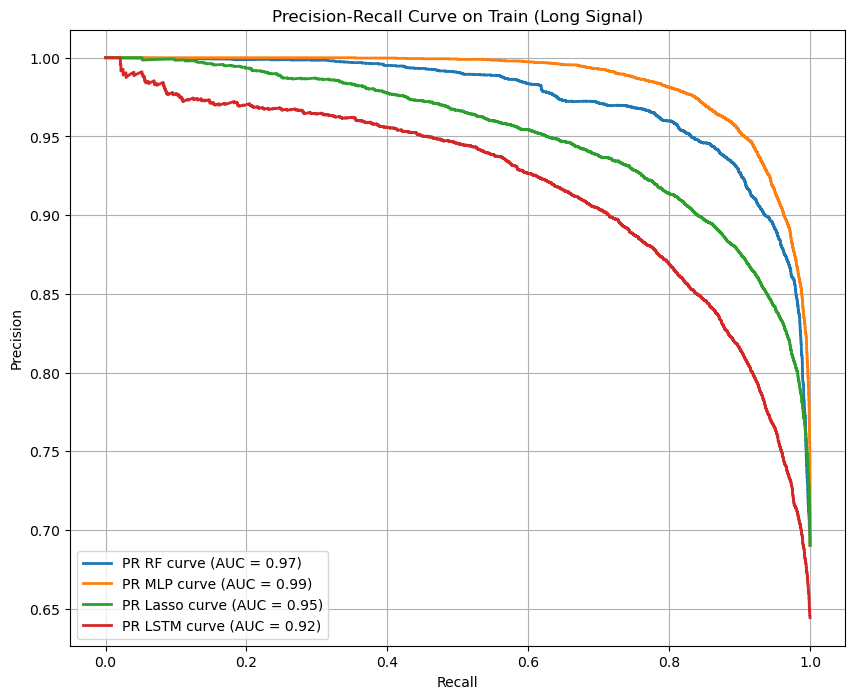

In [67]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

prediction_rf = rf_model.predict_proba(bestX)[:, 1]


precision, recall, _ = precision_recall_curve(bestY, prediction_rf)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR RF curve (AUC = {pr_auc:.2f})')

prediction_mlp = mlp_model.predict(bestX)


precision, recall, _ = precision_recall_curve(bestY, prediction_mlp)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR MLP curve (AUC = {pr_auc:.2f})')

prediction_lasso = lasso_model.predict(bestX)

precision, recall, _ = precision_recall_curve(bestY, prediction_lasso)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR Lasso curve (AUC = {pr_auc:.2f})')

prediction_lstm = lstm_model.predict(bestX_lstm)


precision, recall, _ = precision_recall_curve(bestY_lstm, prediction_lstm)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR LSTM curve (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Train (Long Signal)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


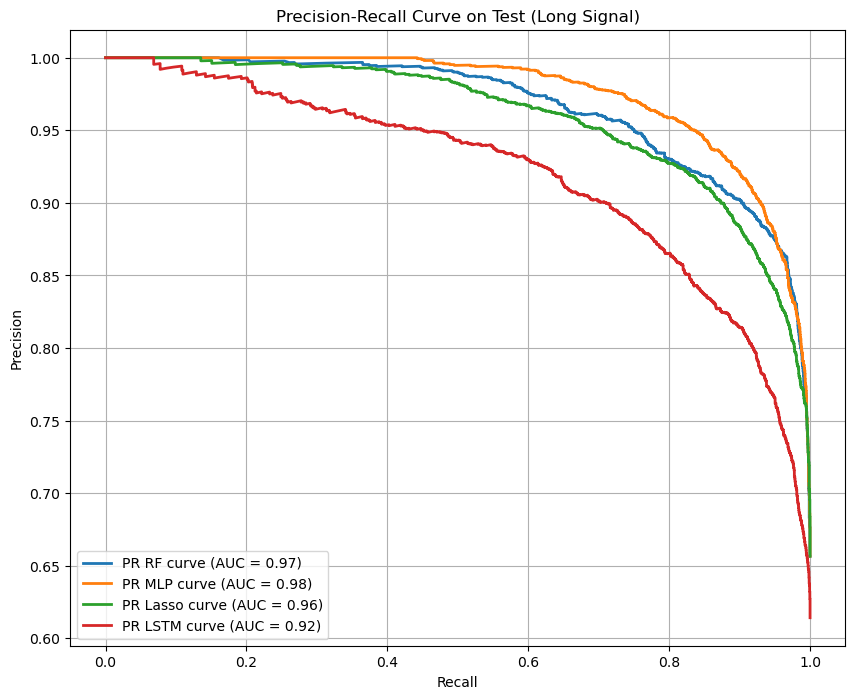

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

prediction_rf = rf_model.predict_proba(bestX)[:, 1]


precision, recall, _ = precision_recall_curve(bestY, prediction_rf)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR RF curve (AUC = {pr_auc:.2f})')

prediction_mlp = mlp_model.predict(bestX)


precision, recall, _ = precision_recall_curve(bestY, prediction_mlp)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR MLP curve (AUC = {pr_auc:.2f})')

prediction_lasso = lasso_model.predict(bestX)

precision, recall, _ = precision_recall_curve(bestY, prediction_lasso)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR Lasso curve (AUC = {pr_auc:.2f})')

prediction_lstm = lstm_model.predict(bestX_lstm)


precision, recall, _ = precision_recall_curve(bestY_lstm, prediction_lstm)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=2, label=f'PR LSTM curve (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test (Long Signal)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
